In [1]:
%config IPCompleter.use_jedi = False

### Image Captioning
- Generating Captions for Images
- Reference blog - <a href="https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8">Image Captioning with Keras</a>
- Dataset Download Link - <a href="https://www.kaggle.com/shadabhussain/flickr8k">Flickr 8k Dataset</a>

` 6000 Images - Training, 1000 Images - Validation, 1000 Images - Testing `

` 5 Captions per Image `

### Steps
- Data Collection
- Understanding the Data
- Data Cleaning
- Loading the training set
- Data Preprocessing - Images
- Data Preprocessing - Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

### Import all the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import tensorflow.keras.applications.vgg16 as VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import add

### Data Collection

In [3]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [4]:
captions = readTextFile("Dataset/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [5]:
captions[0].split('\t')
# format = img_id#index caption

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [6]:
print(len(captions))

40460


In [7]:
# Dictionary to Map each Image with the list of captions it has
# d[img_id] = list of different captions
descriptions = {}

for x in captions:
    first, second = x.split('\t')
    img_id = first.split('.')[0]
    
    # check if image_id already present in dictionary or not
    if descriptions.get(img_id) is None:
        descriptions[img_id] = []
    descriptions[img_id].append(second)

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

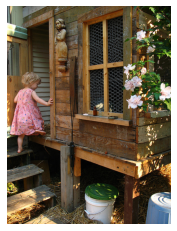

In [9]:
IMG_PATH = "Dataset/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

### Data Cleaning

In [10]:
def clean_text(sentence):
    # Main purpose is to reduce the vocab size
    sentence = sentence.lower() # Convert to lower case
    sentence = re.sub("[^a-z]+"," ",sentence) # substitute everything with a space which is not made of alphabets
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1] # all words with single alphabet
    sentence = " ".join(sentence)
    return sentence

In [11]:
# example
clean_text("A robrer robbed the house # 64 in the night")

'robrer robbed the house in the night'

In [12]:
# Clean all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [13]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
# Write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

### Creating Vocab
`Set of all unique words that our model can predict`

In [15]:
descriptions = None
with open("descriptions.txt","r") as f:
    descriptions = f.read() # this will be a string and not a python dictionary

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [16]:
print(type(descriptions))

<class 'dict'>


In [17]:
# Vocab
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size %d"% len(vocab))

Vocab Size 8424


In [18]:
# Total number of words accross all the sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Words %d"% len(total_words))

Total Words 373837


In [19]:
# Out of 373837, only 8424 words are unique

In [20]:
# Filter words from the vocab according to certain threshold frequency

In [21]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt))

8424


In [22]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]

total_words = [x[0] for x in sorted_freq_cnt]

In [23]:
print(len(total_words))
# Final vocab size

1845


### Prepare Train/Test Set

In [24]:
train_file_data = readTextFile("Dataset/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Dataset/Flickr_TextData/Flickr_8k.testImages.txt")

In [25]:
train = [img_name.split('.')[0] for img_name in train_file_data.split("\n")[:-1]]
test = [img_name.split('.')[0] for img_name in test_file_data.split("\n")[:-1]]

In [26]:
print(train[:10])
print()
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [27]:
# Prepare descriptions for the training data
# Tweak - Add a <s> and <e> token to our training data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
 - Images --> Features
 - Text --> Features

### Image Feature Extraction
Using Pre-Trained Model Technique of Transfer Learning

Model in use : `RESNET-50`

NOTE: Resnet-50 is not a Sequential Model i.e. there is some branching. It has skip connections which allows the deep networks to learn without facing the issue of vanishing gradients.

In [29]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
model_new = Model(model.input,model.layers[-2].output) 
# model_new includes just the Conv. Base of RESNET- 50

In [31]:
def preprcess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [32]:
# img = preprcess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
# plt.imshow(img[0])
# plt.axis('off')
# plt.show()

In [33]:
def encode_img(img):
    img = preprcess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector.reshape((-1,))
    # print(feature_vector.shape)
    return feature_vector

In [34]:
encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([[0.06536534, 0.1678269 , 0.32518426, ..., 0.05111525, 0.32817894,
        1.0043339 ]], dtype=float32)

In [35]:
start = time()
encoding_train = {}
# image_id --> feature_vector extracted from ResNet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in progress Time Step %d"%ix)
end = time()
print("Total Time Taken : ",(end-start))

Encoding in progress Time Step 0
Encoding in progress Time Step 100
Encoding in progress Time Step 200
Encoding in progress Time Step 300
Encoding in progress Time Step 400
Encoding in progress Time Step 500
Encoding in progress Time Step 600
Encoding in progress Time Step 700
Encoding in progress Time Step 800
Encoding in progress Time Step 900
Encoding in progress Time Step 1000
Encoding in progress Time Step 1100
Encoding in progress Time Step 1200
Encoding in progress Time Step 1300
Encoding in progress Time Step 1400
Encoding in progress Time Step 1500
Encoding in progress Time Step 1600
Encoding in progress Time Step 1700
Encoding in progress Time Step 1800
Encoding in progress Time Step 1900
Encoding in progress Time Step 2000
Encoding in progress Time Step 2100
Encoding in progress Time Step 2200
Encoding in progress Time Step 2300
Encoding in progress Time Step 2400
Encoding in progress Time Step 2500
Encoding in progress Time Step 2600
Encoding in progress Time Step 2700
Enco

In [36]:
# Store Everything to the disk
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [37]:
start = time()
encoding_test = {}
# image_id --> feature_vector extracted from ResNet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Test Encoding in progress Time Step %d"%ix)
end = time()
print("Total Time Taken(test) : ",(end-start))

Test Encoding in progress Time Step 0
Test Encoding in progress Time Step 100
Test Encoding in progress Time Step 200
Test Encoding in progress Time Step 300
Test Encoding in progress Time Step 400
Test Encoding in progress Time Step 500
Test Encoding in progress Time Step 600
Test Encoding in progress Time Step 700
Test Encoding in progress Time Step 800
Test Encoding in progress Time Step 900
Total Time Taken(test) :  48.427138805389404


In [38]:
# Store Everything to the disk
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Load Data from pkl file

In [39]:
with open("encoded_train_features.pkl","rb") as f:
    encoding_train = pickle.load(f)

In [40]:
with open("encoded_test_features.pkl","rb") as f:
    encoding_test = pickle.load(f)

### Preprocessing Captions

In [41]:
# Vocab
len(total_words)

1845

In [42]:
word_2_idx = {}
idx_2_word = {}

for i,word in enumerate(total_words):
    word_2_idx[word] = i+1
    idx_2_word[i+1] = word

In [43]:
print(len(idx_2_word))

1845


In [44]:
# Add startseq and endseq to dictionary
idx_2_word[1846] = "startseq"
word_2_idx["startseq"] = 1846

idx_2_word[1847] = "endseq"
word_2_idx["endseq"] = 1847

vocab_size = len(word_2_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [45]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

35


### Data Loader (Generator)

In [46]:
def data_generator(train_descriptions,encoding_train,word_2_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key]
            photo = photo.reshape((2048,))
            for desc in desc_list:
                
                seq = [word_2_idx[word] for word in desc.split() if word in word_2_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denotes padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding="post")[0]
                    yi = to_categorical([yi],num_classes = vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n=0

### Word Embeddings

In [47]:
f = open("Dataset/glove.6B.50d.txt",encoding='utf8')

In [48]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [49]:
f.close()

In [50]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [51]:
def get_emebedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_2_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [52]:
embedding_matrix = get_emebedding_matrix()

In [53]:
embedding_matrix.shape

(1848, 50)

In [54]:
embedding_matrix[1847] # endseq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model Architecture

In [55]:
# Images as input
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation="relu")(inp_img1)

In [56]:
# Captions as input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.2)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [57]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [59]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [60]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

### Model Training

In [62]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [63]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_2_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save("./model_weights/model_"+str(i)+".h5")

In [64]:
train()

C:\Users\win\anaconda3\envs\tensorflowgpu2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


   5/2000 [..............................] - ETA: 29s - loss: 3.3705

C:\Users\win\anaconda3\envs\tensorflowgpu2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 26s 13ms/step - loss: 2.4683


In [70]:
model = load_model("./model_weights/model_19.h5")

### Predictions

In [81]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence,],maxlen=max_len,padding="post")
        
        y_pred = model.predict([photo,sequence])
        y_pred = y_pred.argmax() # Word with maximum probab - Greedy Sampling
        word = idx_2_word[y_pred]
        in_text += (' '+ word)
        
        if word=="endseq":
            break
        
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

person in swimsuit is diving in the ocean


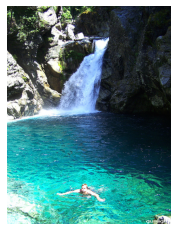

man in harness skates and backpack


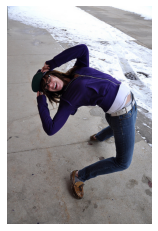

man in red shirt and helmet is riding bike


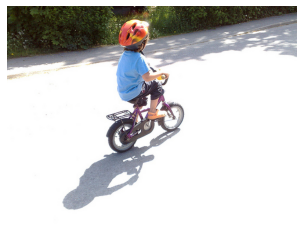

boy in blue shirt and blue shorts is running


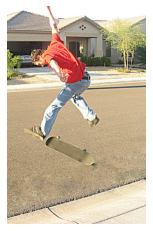

dog is jumping up to catch ball


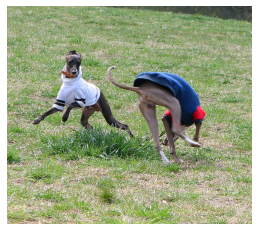

terrier running in field


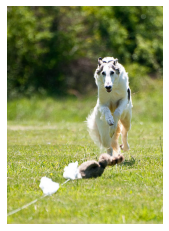

man in red shirt is standing in front of roller coaster coaster


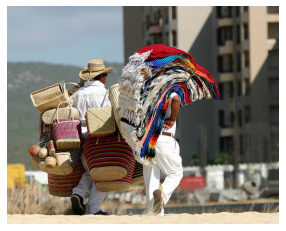

group of people stand in front of building


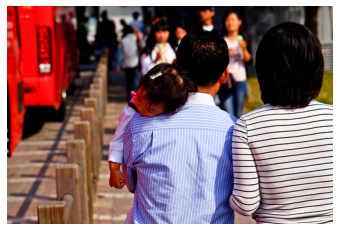

man sits on rock ledge


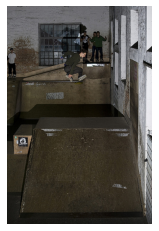

group of people are playing soccer on grassy field


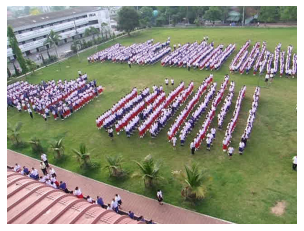

man in black shirt and white shorts jumping off high platform


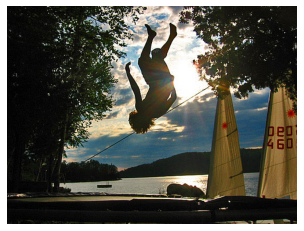

man in blue shirt and helmet is jumping his bike over graffiti


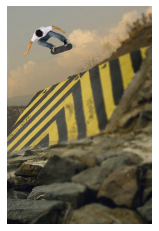

dog swims in the water


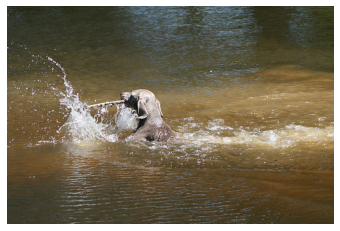

boy in green shirt is holding onto his head on his head


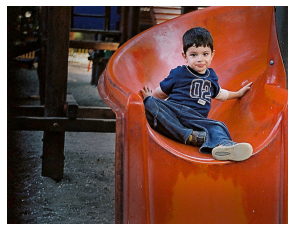

man in red shirt is sitting on rock next to the mountains


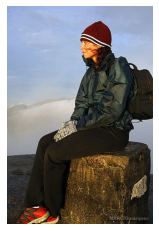

In [82]:
# Pick some random images and see results
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name]
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

### We can see some pretty interesting results here